In [1]:
%matplotlib inline
import os
import sys
import time
import torch # 导入 pytorch 
import sklearn
import torchvision # 导入视觉库
import numpy as np
import pandas as pd
from torch import nn # 导入网络层子库
from torch import optim # 导入优化器
from torchsummary import summary # 从 torchsummary 工具包中导入 summary 函数
from torch.nn import functional as F # 导入网络层函数子库
from matplotlib import pyplot as plt
from utils import one_hot, plot_curve, plot_image

print(sys.version_info)
for module in torch, torchvision, np, pd, sklearn:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
torch 1.10.2
torchvision 0.11.3
numpy 1.19.3
pandas 1.3.3
sklearn 0.22.2.post1


In [2]:

''''   超参数   '''

batch_size = 512 # 批大小
n_epochs = 3
# 学习率
learning_rate = 0.01
# 动量
momentum = 0.9

'''  Hyperparameters   '''

'  Hyperparameters   '

In [3]:
'''  Step 1 下载训练集和测试集，对数据进行预处理  '''

# 训练数据集，从网络下载 MNIST数据集 保存至 mnist_data 文件夹中
# 创建 DataLoader 对象 (iterable, 类似 list，可用 iter() 进行访问)，方便批量训练，将数据标准化在 0 附近并随机打散
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data', train = True, download = True,
                                     # 图片预处理
                                     transform = torchvision.transforms.Compose([
                                         # 转换为张量
                                         torchvision.transforms.ToTensor(),
                                         # 标准化
                                         torchvision.transforms.Normalize(
                                         (0.1307,), (0.3081,))
                                     ])),
    batch_size = batch_size, shuffle = True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data/', train = False, download = True,
                                     transform = torchvision.transforms.Compose([
                                         torchvision.transforms.ToTensor(),
                                         torchvision.transforms.Normalize(
                                         (0.1307,), (0.3081,)) # 使用训练集的均值和方差
                                     ])),
    batch_size = batch_size, shuffle = False)

torch.Size([512, 1, 28, 28]) torch.Size([512]) tensor(-0.4242) tensor(2.8215)


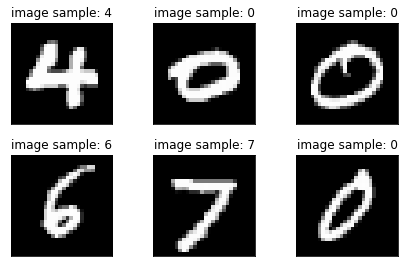

In [4]:
'''   Step 2。 展示样本数据   '''


def show_sample_image():
    # 使用 iter() 从 DataLoader 中取出 迭代器， next() 选取下一个迭代器
    x, y = next(iter(train_loader))
    # 输出数据的 shape，以及输入图片的最小最大强度值
    print(x.shape, y.shape, x.min(), x.max())
    # 使用自己封装的 polt_image() 函数对图片进行展示
    plot_image(x, y, 'image sample')
    
show_sample_image()    

In [5]:
'''   Step 3。 搭建网络模型   '''

class Net(nn.Module):
    # 网络初始化
    def __init__(self):
        super(Net, self).__init__()
        # y = wx + b
        # 三层全连接层神经网络
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    # 定义神经网络前向传播逻辑
    def forward(self, x):
        # x : [b, 1, 28, 28]
        # h1 = relu(w1x + b1)
        x = F.relu(self.fc1(x))
        # h2 = relu(w2x + b2)
        x = F.relu(self.fc2(x))
        # h3 = w3h2 + b3
        x = self.fc3(x)
        # 直接返回向量 [b, 10], 通过 argmax 即可得到分类预测值
        return x 
        '''
        也可直接将向量经过 softmax 函数得到分类预测值
        return F.log_softmax(x, dim = 1)
        '''
        
# 使用 summary 函数之前，需要使用 device 来指定网络在 GPU 还是 CPU 运行
device = torch.device("cuda" if torch.cuda.is_available() else "gpu") 
print(torch.cuda.is_available())
net = Net().to(device)
# 所有的张量都需要进行 `.to(device)` 
print(net)
summary(net, (1, 28 * 28))
# summary(your_model, input_size=(channels, H, W))
# input_size 要求符合模型的输入要求, 用来进行前向传播

True
Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
            Linear-2                [-1, 1, 64]          16,448
            Linear-3                [-1, 1, 10]             650
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.83
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


epoch:0, iteration:0, loss:0.12122594565153122
epoch:0, iteration:10, loss:0.09926386922597885
epoch:0, iteration:20, loss:0.08644484728574753
epoch:0, iteration:30, loss:0.07972756773233414
epoch:0, iteration:40, loss:0.07488133013248444
epoch:0, iteration:50, loss:0.07044463604688644
epoch:0, iteration:60, loss:0.06637724488973618
epoch:0, iteration:70, loss:0.06356173753738403
epoch:0, iteration:80, loss:0.05986356735229492
epoch:0, iteration:90, loss:0.05715459585189819
epoch:0, iteration:100, loss:0.05593841150403023
epoch:0, iteration:110, loss:0.05120903253555298
epoch:1, iteration:0, loss:0.05355915054678917
epoch:1, iteration:10, loss:0.050536610186100006
epoch:1, iteration:20, loss:0.04767081141471863
epoch:1, iteration:30, loss:0.048206694424152374
epoch:1, iteration:40, loss:0.04414692148566246
epoch:1, iteration:50, loss:0.04389065504074097
epoch:1, iteration:60, loss:0.042195286601781845
epoch:1, iteration:70, loss:0.044043783098459244
epoch:1, iteration:80, loss:0.042298

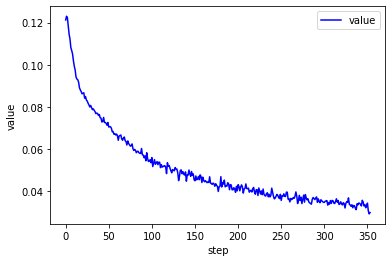

In [6]:
'''   Step 4. 在训练集上进行训练   '''


def MNIST_trains(net):
    # 选择 SGD 随机梯度下降算法作为优化方法，导入网络参数、学习率以及动量
    optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = momentum)

    train_loss = []

    for epoch in range(n_epochs):
        for batch_idx, (x, y) in enumerate(train_loader):
            # 将数据 x 打平
            # x: [b, 1, 28, 28] -> [b, 784]
            x = x.view(x.size(0), 28 * 28).to(device)
            # 经过神经网络 [b, 784] -> [b, 10]
            out = net(x).to(device)
            # 将数据的真实标签 y 转换为 one hot 向量
            y_one_hot = one_hot(y).to(device)
            # 计算 网络预测值 out 与 真实标签 y 的 mse 均方差
            # loss = mse(out, y_one_hot)
            loss = F.mse_loss(out, y_one_hot)
            # zero grad 清空历史梯度数据
            optimizer.zero_grad()
            # 进行反向传播，计算当前梯度
            loss.backward()
            # 根据当前梯度更新网络参数
            # w' = w - lr * grad
            optimizer.step()
            # 保存当前的损失函数值
            train_loss.append(loss.item())
            # 每 10 步 输出一次数据查看训练情况
            if batch_idx % 10 == 0:
                print(f"epoch:{epoch}, iteration:{batch_idx}, loss:{loss.item()}")
    # 绘制损失函数图像
    # [w1, b1, w2, b2, w3, b3]
    plot_curve(train_loss)
    
MNIST_trains(net)

In [7]:
'''   Step 5. 在测试集中进行测试   '''


def MNIST_tests(net):
    # 在测试集中预测正确的总数
    total_correct = 0
    # 迭代所有测试数据
    for x, y in test_loader:
        # 将图片 x 打平
        x = x.view(x.size(0), 28 * 28).to(device)
        # 经过已经训练好的神经网络 net
        out = net(x).to(device)
        # 预测值 pred: argmax 返回指定维度最大值的索引
        # out [b, 10] -> pred [b]
        pred = out.argmax(dim = 1).to(device)
        # 计算预测值等于真实标签的样本数量
        correct = pred.eq(y.to(device)).sum().float().item()
        # 计算预测正确样本的总数
        total_correct += correct
    # 总样本数即为测试集的长度
    total_num = len(test_loader.dataset)
    # 计算正确率
    acc = total_correct / total_num
    # 输出测试正确率 acc
    print("test_acc:", acc)
    
MNIST_tests(net)

test_acc: 0.8927


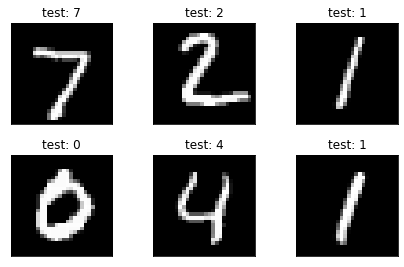

In [8]:
'''   Step 6。 展示样本数据   '''


def show_test_sample_image(net):
    x, y = next(iter(test_loader))
    out = net(x.view(x.size(0), 28 * 28).to(device)).to(device)
    pred = out.argmax(dim = 1).to(device)
    plot_image(x, pred, 'test')
    
show_test_sample_image(net)

In [9]:
'''
def solve():
    show_sample_image()

    net = Net()

    MNIST_trains(net)
    MNIST_tests(net)

    show_test_sample_image(net)


if __name__ == "__main__":
    solve()
'''

'\ndef solve():\n    show_sample_image()\n\n    net = Net()\n\n    MNIST_trains(net)\n    MNIST_tests(net)\n\n    show_test_sample_image(net)\n\n\nif __name__ == "__main__":\n    solve()\n'